In [50]:
import numpy as np

import ufl
from dolfinx import fem, io, mesh, plot
from ufl import ds, dx, grad, inner

from mpi4py import MPI
from petsc4py.PETSc import ScalarType

In [51]:
msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, 0.0), (1.0, 1.0)), n=(50, 50),
                            cell_type=mesh.CellType.triangle,)
V = fem.FunctionSpace(msh, ("Lagrange", 1))

In [52]:
facets_1 = mesh.locate_entities_boundary(msh, dim=1,
                                       marker=lambda x: np.logical_or(np.isclose(x[0], 0.0),
                                                                      np.isclose(x[0], 1.0)))

In [53]:
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

In [54]:
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

In [55]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)
f = +1
g = 1000
a = inner(grad(u), grad(v)) * dx
L = inner(f, v) * dx + inner(g, v) * ds

In [56]:
problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [57]:
with io.XDMFFile(msh.comm, "out_poisson/poisson.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_function(uh)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



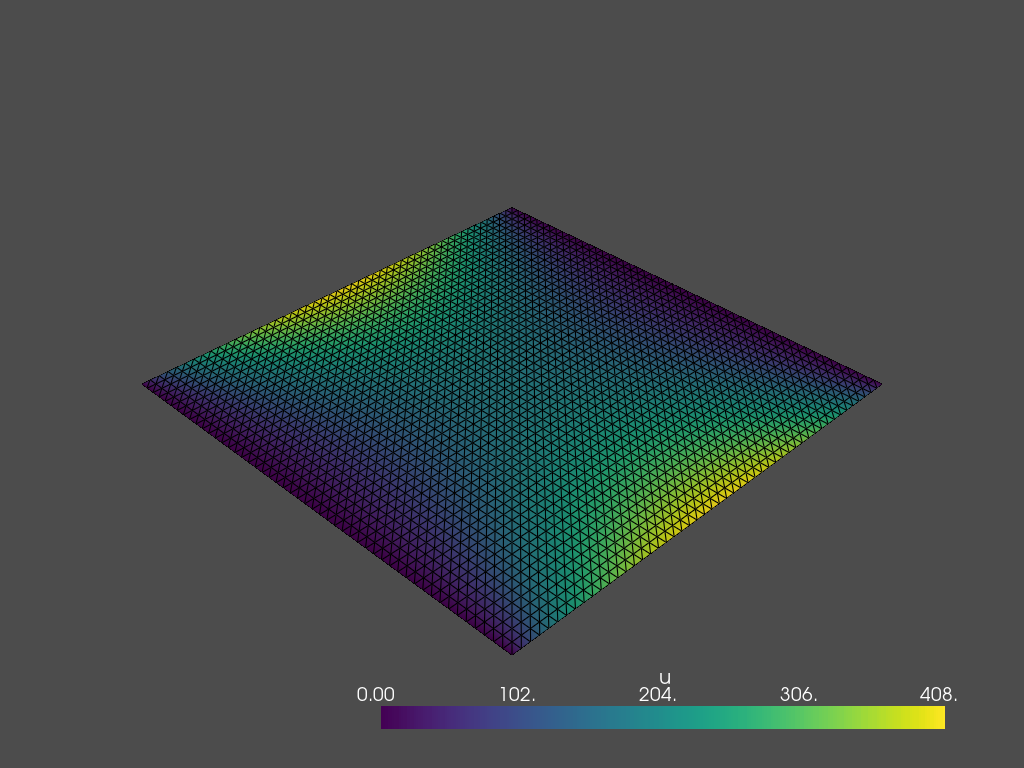

In [59]:
try:
    import pyvista
    cells, types, x = plot.create_vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    # plotter.add_mesh(warped)
    plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")